# Feature extraction from the Labelled Faces in the Wild dataset

Finding the principal components of a set of images -- or 'eigenfaces' (LOL)

In [3]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize = 0.7)

In [4]:
people.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

Let's have a look at some of the data!

In [5]:
image_shape = people.images[0].shape

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

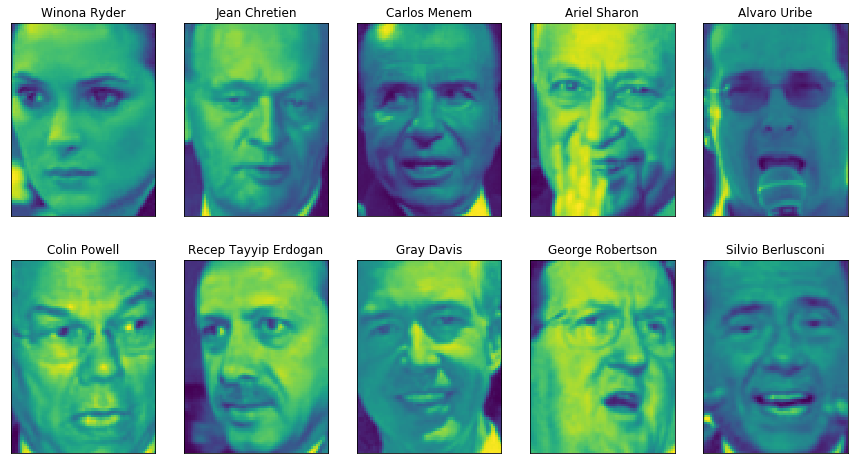

In [7]:
fig, axes = plt.subplots(2,5,figsize = (15,8), subplot_kw ={'xticks':(), 'yticks':()})

for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

How big is the dataset and how many different people are represented?

In [8]:
print('people.images.shape: {}'.format(people.images.shape))

people.images.shape: (3023, 87, 65)


So, 3023 images, all 87x65 pixels.

In [9]:
print('Number of classes: {}'.format(len(people.target_names)))

Number of classes: 62


There are 62 distinct names in the target_names vector. How often does each of the targets occur?

In [10]:
import numpy as np

In [11]:
counts = np.bincount(people.target)
print(counts)

[ 39  35  21  36  20  77  42  24  29  21 236  31 121  22 530 109  44  26
  30  22  39  71  20  28  52  55  21  42  21  24  20  53  31  23  28  60
  32  41  22  41  48  29  33  20  22  37  20  22  30  27  32  26  23  52
  33  23  25  33 144  32  49  24]


In [12]:
print(people.target_names.shape)
print(people.target.shape)
print(people.data.shape)

(62,)
(3023,)
(3023, 5655)


In [13]:
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print('{0:25}{1:3}'.format(name, count), end = ' ')
    if (i+1)%3 == 0:
        print()

Alejandro Toledo          39 Alvaro Uribe              35 Amelie Mauresmo           21 
Andre Agassi              36 Angelina Jolie            20 Ariel Sharon              77 
Arnold Schwarzenegger     42 Atal Bihari Vajpayee      24 Bill Clinton              29 
Carlos Menem              21 Colin Powell             236 David Beckham             31 
Donald Rumsfeld          121 George Robertson          22 George W Bush            530 
Gerhard Schroeder        109 Gloria Macapagal Arroyo   44 Gray Davis                26 
Guillermo Coria           30 Hamid Karzai              22 Hans Blix                 39 
Hugo Chavez               71 Igor Ivanov               20 Jack Straw                28 
Jacques Chirac            52 Jean Chretien             55 Jennifer Aniston          21 
Jennifer Capriati         42 Jennifer Lopez            21 Jeremy Greenstock         24 
Jiang Zemin               20 John Ashcroft             53 John Negroponte           31 
Jose Maria Aznar          23 Jua

There are so many pictures of George Bush, we need to make sure that no more than 50 images of each person are included. Otherwise we will likely be just finding the principal components of G. Bush's face, and comparing everyone else to him. Which seems a tad...sycophantic?

In [27]:
#make a mask that ensures we only have up to the first 50 images of any given person.

In [14]:
mask = np.zeros(people.target.shape, dtype = np.bool)

In [15]:
np.unique(people.target) #the number labels of the people

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61])

In [16]:
people.target_names[14]

'George W Bush'

So, for example, this array represents the first 50 members of the image set that correspond to 'George Bush'.

In [17]:
np.where(people.target == 14)[0][:50]

array([ 10,  11,  15,  18,  21,  23,  24,  25,  26,  46,  52,  53,  62,
        82,  84, 104, 106, 116, 117, 122, 132, 146, 154, 166, 174, 176,
       183, 189, 191, 193, 198, 199, 203, 214, 223, 227, 233, 234, 235,
       236, 249, 257, 260, 264, 269, 270, 272, 275, 282, 285])

In [18]:
number_labels = np.unique(people.target)
for target in number_labels:
    mask[np.where(people.target == target)[0][:50]] =1 #do this for every target label

In [19]:
X_people = people.data[mask] #just the image data for the first 50 for each face.
Y_people = people.target[mask] #just the number labels for the first 50 for each person. 

Scale the greyscale to be between 0 and 1.

In [20]:
X_people = X_people/255
print(np.bincount(Y_people)) #the same as bincount for people.target but now capped at 50.

[39 35 21 36 20 50 42 24 29 21 50 31 50 22 50 50 44 26 30 22 39 50 20 28
 50 50 21 42 21 24 20 50 31 23 28 50 32 41 22 41 48 29 33 20 22 37 20 22
 30 27 32 26 23 50 33 23 25 33 50 32 49 24]


## Who does the face belong to?

When we want to answer this question, given a training database of faces, there are a number of different ways we can approach it. 

We could, for instance, take an identically sized image to those in our database, and compare pixel by pixel the value of each pixel in the image to all of those in the training database. So in this case, with >5600 features, and 62 pieces of training data (single points in this huge higher-dimensional space) we are finding, for a given input test image, which is the nearest neighbour. 

To examine whether this is a sensible way to solve the problem, we can try using the K-nearest neighbours algorithm, which does exactly that. It finds, in this higher dimensional space, which is the closest image and then assigns the label of that image to our input. (This is using k = 1 neighbours, obviously). 

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_people, Y_people, stratify= Y_people, random_state=0)
#'stratify' here makes sure that if, for example, Geogre Bush's face makes up 25% of the input, it makes up 25% of both
#the train and the tests sets, as otherwise we would expect increased inaccuracy. 
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)
print('Test score of 1-nn: {:.2f}'.format(knn.score(X_test, y_test)))

Test score of 1-nn: 0.23


So in other words, 23% of the time it gets it right. If you were to guess randomly which face it was from the dataset, you'd get it right 1/62 = 1.6% of the time, so it is some improvement. However, humans can do much better. Can we find a way to make this much more effective?

One of the reasons humans do better is because we don't go pixel by pixel, but instead focus on overall features, much like the principal components of faces. It might not be conscious, but we do something like filter out eyes, mouth, nose, the distance between all these things and their sizes. Our brains know to recognise these features in the first place (also interesting to meditate on what is going on with people who have Prosopagnosia).

Obviously, pixel by pixel is also bad because it is not robust to the framing of the face in the image. 

So, let's think about whether we can do principal component analysis of our faces.

## PCA and Scaling the principal components

In this case, the data itself is already between 0 and 1 for each pixel. However, for the principal components themselves, we can rescale them so that the data is represented as a sphere in the higher-dimensional space of the PCs, rather than tending to be skewed more along one of the PCs

We use n = 100 components, and transform the training and test data.

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 100, whiten = True, random_state = 0).fit(X_train) #set up the pca and use the X_train data to 
#find the PCs. Whiten scales the PCs. 
X_train_pca = pca.transform(X_train) #transform training data on to PC axes. 
X_test_pca = pca.transform(X_test) 

In [23]:
print('X_train shape: {}'.format(X_train.shape))

X_train shape: (1547, 5655)


In [24]:
print('X_train_pca shape: {}'.format(X_train_pca.shape))

X_train_pca shape: (1547, 100)


The dimensionality of the data has been reduced from the 5655 pixels to just 100 principal components. 

Now, in this space, the KNearestNeighbours classifier may work a little better.

In [25]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train_pca, y_train)
print('Test score of 1-nn: {:.2f}'.format(knn.score(X_test_pca, y_test)))

Test score of 1-nn: 0.31


OK, so it improved a little bit.

## Visualing the eigenfaces

In [26]:
print('pca.components_.shape: {}'.format(pca.components_.shape))

pca.components_.shape: (100, 5655)


The principal components also have to be images, of the same size as the original data, but now there are 100 'eigenfaces'.

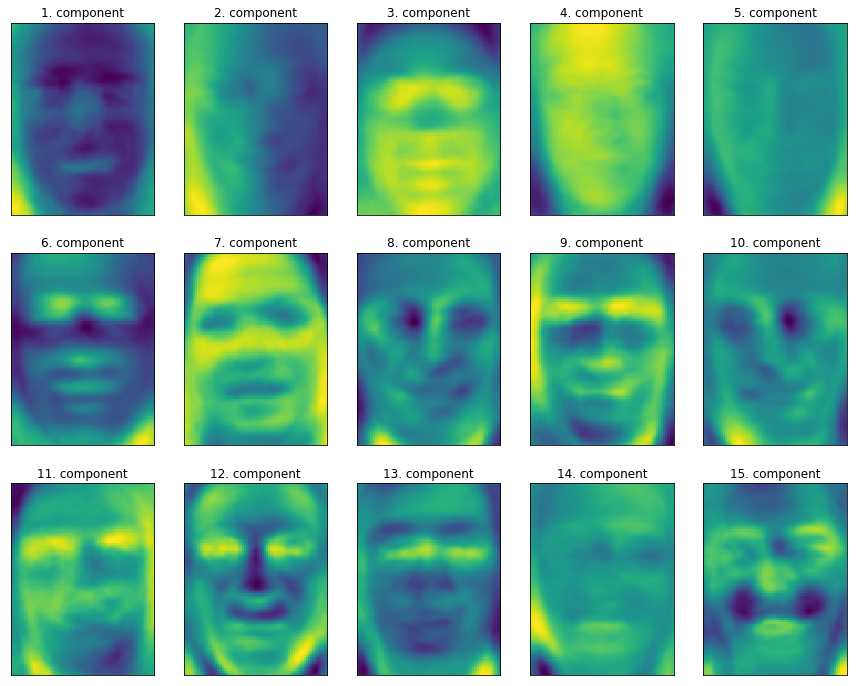

In [27]:
fig, axes = plt.subplots(3,5,figsize = (15,12), subplot_kw = {'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap='viridis')
    ax.set_title('{}. component'.format((i+1)))

This faintly horrifying set of ghosts are the first 15 eigenfaces of the dataset. 

(Idea, for fun: take a photo of own face and work out which class I belong to -- am I more of an Erdogan or Winona Ryder? Maybe I don't want that answered.)

## Finding the weighted sum of PCs that compose members of the training set -- how many do you need to accurately reconstruct?

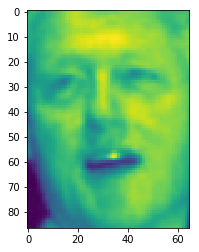

In [38]:
plt.imshow(X_train[0].reshape(image_shape))

In [40]:
y_train[0] #this is Bill Clinton.

8

In [42]:
Bill_inverse = pca.inverse_transform(X_train_pca[0])

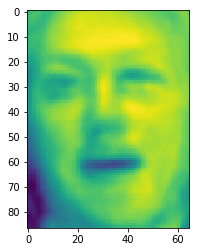

In [43]:
plt.imshow(Bill_inverse.reshape(image_shape))

This is not as obviously Bill Clinton's face, because it only takes the first 100 components, and so it cannot reconstruct very well. We can deliberately force our PCA to include more components and see whether that helps. 

In [46]:
pca_more = PCA(n_components = 500, whiten = True, random_state = 0).fit(X_train) #set up the pca and use the X_train data to 
#find the PCs. Whiten scales the PCs. 
X_train_pca_more = pca_more.transform(X_train) #transform training data on to PC axes. 
X_test_pca_more = pca_more.transform(X_test) 

In [47]:
Bill_inverse_more = pca_more.inverse_transform(X_train_pca_more[0])

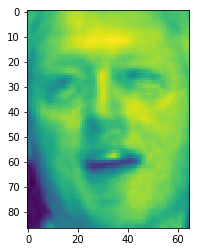

In [48]:
plt.imshow(Bill_inverse_more.reshape(image_shape))

This is an improvement. We could do a systematic study of how good PCA is with increasing numbers of components, but this seems a bit of overkill. 